## Description:
Decomposes Sd into the 3 terms: Source term, Conduction term, (Species) Diffusion term. Looks at the pairwise plot between the three terms and between each term and Sd.

In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flamekit.io_fronts import Case, load_fronts

### Read config file and define helper functions

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/Sd_decomposition_analysis" / "Sd_decomposition_analysis.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
TIME_STEPS = list(CFG["TIME_STEPS"])

PROGRESS_LEVELS = list(CFG["PROGRESS_LEVELS"])
POST = bool(CFG["POST"])
MULTIPLE_RUNS = bool(CFG["MULTIPLE_RUNS"])
N_RUN = int(CFG["N_RUN"])

# Features and target
TERMS = list(CFG["TERMS"])
TARGET = str(CFG["TARGET"])

# Curvature coloring
CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])

# Sd filter (set min/max to enable; use None for no bound)
SD_COLUMN = str(CFG["SD_COLUMN"])
SD_MIN = CFG["SD_MIN"]
SD_MAX = CFG["SD_MAX"]

# Plot controls
FIG_DPI = 250
SCATTER_S = float(CFG["SCATTER_S"])
ALPHA = float(CFG["ALPHA"])
RASTERIZE = bool(CFG["RASTERIZE"])

# Color cross-plots by DW_FDS (recommended)
COLOR_CROSS_BY_TARGET = bool(CFG["COLOR_CROSS_BY_TARGET"])

# Minimum samples to plot
MIN_SAMPLES = int(CFG["MIN_SAMPLES"])

# Save figures
SAVE_FIGS = bool(CFG["SAVE_FIGS"])
OUT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUT_BASE_DIR"])
ISO_SCATTER_DIR = OUT_BASE_DIR / "isocontour_scatter"

# Output/run directory and file naming
RUN_DIR = OUT_BASE_DIR
CROSS_FNAME_FMT = "cross__{f1}__vs__{f2}"
DWVS_FNAME_FMT = f"dw_vs__{TARGET}__vs__{{feat}}"

# ============================================================
# PLOT STYLE (template-based)
# ============================================================
PLOT_FONT_FAMILY = "Courier New"
PLOT_FONT_SIZE = 20
FIG_SIZE = (6.8, 6.2)
ISO_FIG_SIZE = (7.6, 7.6)
SCATTER_S_ISO = 10
ALPHA_ISO = 0.6

def apply_plot_style() -> None:
    plt.rcParams.update({
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
    })

apply_plot_style()

COLOR_DATA = "#77b5b6"
COLOR_DATA_EDGE = "#378d94"
COLOR_NEUTRAL = "#7e7e7e"

LABEL_SD = r"$\tilde{S}_d^*$"

def style_axes(ax) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

def plot_isocontour_scatter(df: pd.DataFrame, savepath: Path | None = None) -> None:
    fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        df["y"],
        df["x"],
        s=SCATTER_S_ISO,
        alpha=ALPHA_ISO,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.6,
        zorder=3,
        rasterized=RASTERIZE,
    )
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    style_axes(ax)
    ax.set_aspect("equal", adjustable="box")
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath.with_suffix(".png"), dpi=FIG_DPI, bbox_inches="tight")
        fig.savefig(savepath.with_suffix(".pdf"), bbox_inches="tight")
        fig.savefig(savepath.with_suffix(".svg"), bbox_inches="tight")
    plt.show()
    plt.close(fig)

LABEL_MAP = {
    "DW_FDS": LABEL_SD,
    "FDS_source_term": "Source Term",
    "FDS_conduction_term": "Conduction Term",
    "FDS_diffusion_term": "Species Diffusion Term",
}

def format_label(name: str) -> str:
    if name in LABEL_MAP:
        return LABEL_MAP[name]
    return name.replace("_", " ")

# ============================================================
# HELPERS
# ============================================================
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=DATA_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN
        )
    except TypeError:
        return Case(**base_kwargs)

def make_out_dir(lat_size: str, time_step: int, c_val: float) -> Path:
    # Keep same folder naming convention, nested under run directory
    return RUN_DIR / f"h_{lat_size}_t_{time_step}_T_{c_val:g}"

def require_columns(df: pd.DataFrame, cols: list[str], context: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{context} Missing columns: {missing}")

def clean_valid_rows(df: pd.DataFrame, cols_needed: list[str]) -> pd.DataFrame:
    valid = df[cols_needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df.loc[valid.index].copy()

def _is_finite_limit(value: float | None) -> bool:
    return value is not None and np.isfinite(value)

def sd_limits_active(sd_min: float | None, sd_max: float | None) -> bool:
    return _is_finite_limit(sd_min) or _is_finite_limit(sd_max)

def _finite_or_none(value: float | None) -> float | None:
    return value if _is_finite_limit(value) else None

def apply_sd_filter(df: pd.DataFrame, sd_col: str,
                    sd_min: float | None, sd_max: float | None) -> pd.DataFrame:
    if not sd_limits_active(sd_min, sd_max):
        return df
    if sd_col not in df.columns:
        raise ValueError(f"Sd filter requires column '{sd_col}'")
    mask = np.ones(len(df), dtype=bool)
    if _is_finite_limit(sd_min):
        mask &= df[sd_col] >= sd_min
    if _is_finite_limit(sd_max):
        mask &= df[sd_col] <= sd_max
    return df.loc[mask].copy()

def apply_sd_axis_limits(ax, x_col: str, y_col: str, sd_col: str,
                         sd_min: float | None, sd_max: float | None) -> None:
    if not sd_limits_active(sd_min, sd_max):
        return
    if x_col == sd_col:
        ax.set_xlim(left=_finite_or_none(sd_min), right=_finite_or_none(sd_max))
    if y_col == sd_col:
        ax.set_ylim(bottom=_finite_or_none(sd_min), top=_finite_or_none(sd_max))

def save_or_show(fig, savepath: Path | None):
    if savepath is not None:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(savepath.with_suffix(".png"), dpi=FIG_DPI)
        fig.savefig(savepath.with_suffix(".pdf"))
        fig.savefig(savepath.with_suffix(".svg"))
    plt.show()
    plt.close(fig)

def plot_cross_scatter(df: pd.DataFrame, f1: str, f2: str, title: str,
                       savepath: Path | None = None, color_by: str | None = None) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)

    if color_by is None:
        ax.scatter(df[f1], df[f2], s=SCATTER_S, alpha=ALPHA, color=COLOR_DATA, edgecolors=COLOR_DATA_EDGE, linewidths=0.6, rasterized=RASTERIZE)
    else:
        sc = ax.scatter(df[f1], df[f2], c=df[color_by], s=SCATTER_S, alpha=ALPHA,
                        edgecolors=COLOR_DATA_EDGE, linewidths=0.6, rasterized=RASTERIZE)
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label(format_label(color_by))

    ax.set_xlabel(format_label(f1))
    ax.set_ylabel(format_label(f2))
    style_axes(ax)
    apply_sd_axis_limits(ax, f1, f2, SD_COLUMN, SD_MIN, SD_MAX)

    save_or_show(fig, savepath)

def plot_target_vs_feature(df: pd.DataFrame, feat: str, title: str,
                           savepath: Path | None = None, color_by: str | None = None) -> None:
    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)

    if color_by is None:
        ax.scatter(df[feat], df[TARGET], s=SCATTER_S, alpha=ALPHA, color=COLOR_DATA, edgecolors=COLOR_DATA_EDGE, linewidths=0.6, rasterized=RASTERIZE)
    else:
        sc = ax.scatter(df[feat], df[TARGET], c=df[color_by], s=SCATTER_S, alpha=ALPHA,
                        edgecolors=COLOR_DATA_EDGE, linewidths=0.6, rasterized=RASTERIZE, cmap="viridis")
        cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.03)
        cbar.set_label(format_label(color_by))

    ax.set_xlabel(format_label(feat))
    ax.set_ylabel(format_label(TARGET))
    style_axes(ax)
    apply_sd_axis_limits(ax, feat, TARGET, SD_COLUMN, SD_MIN, SD_MAX)

    save_or_show(fig, savepath)










### Run

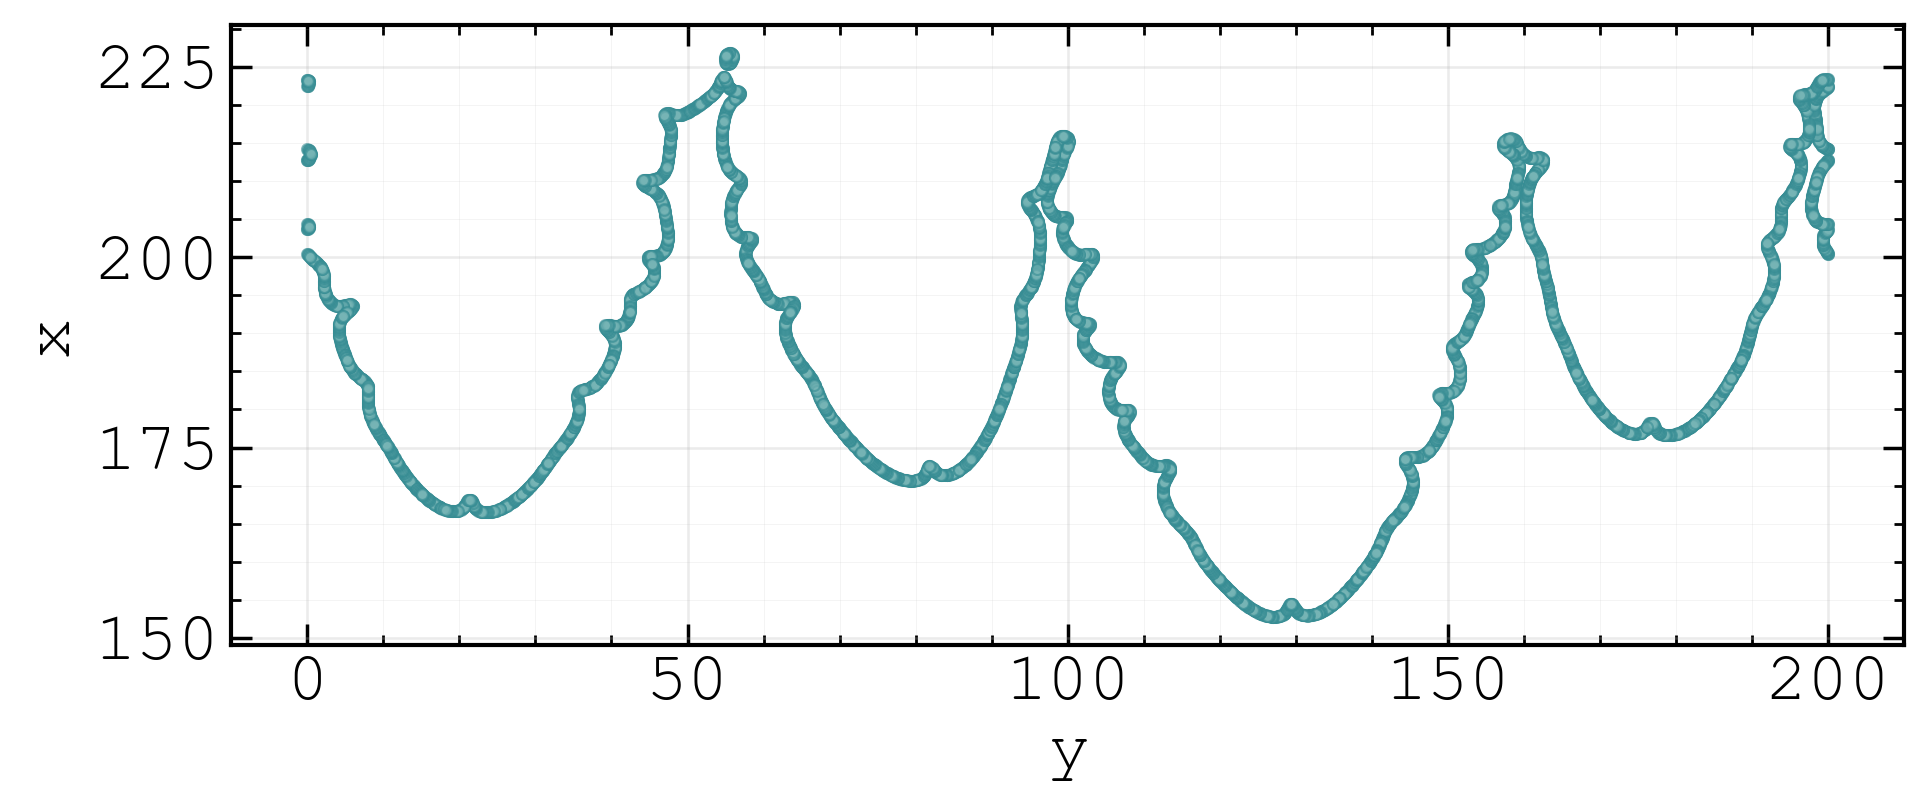

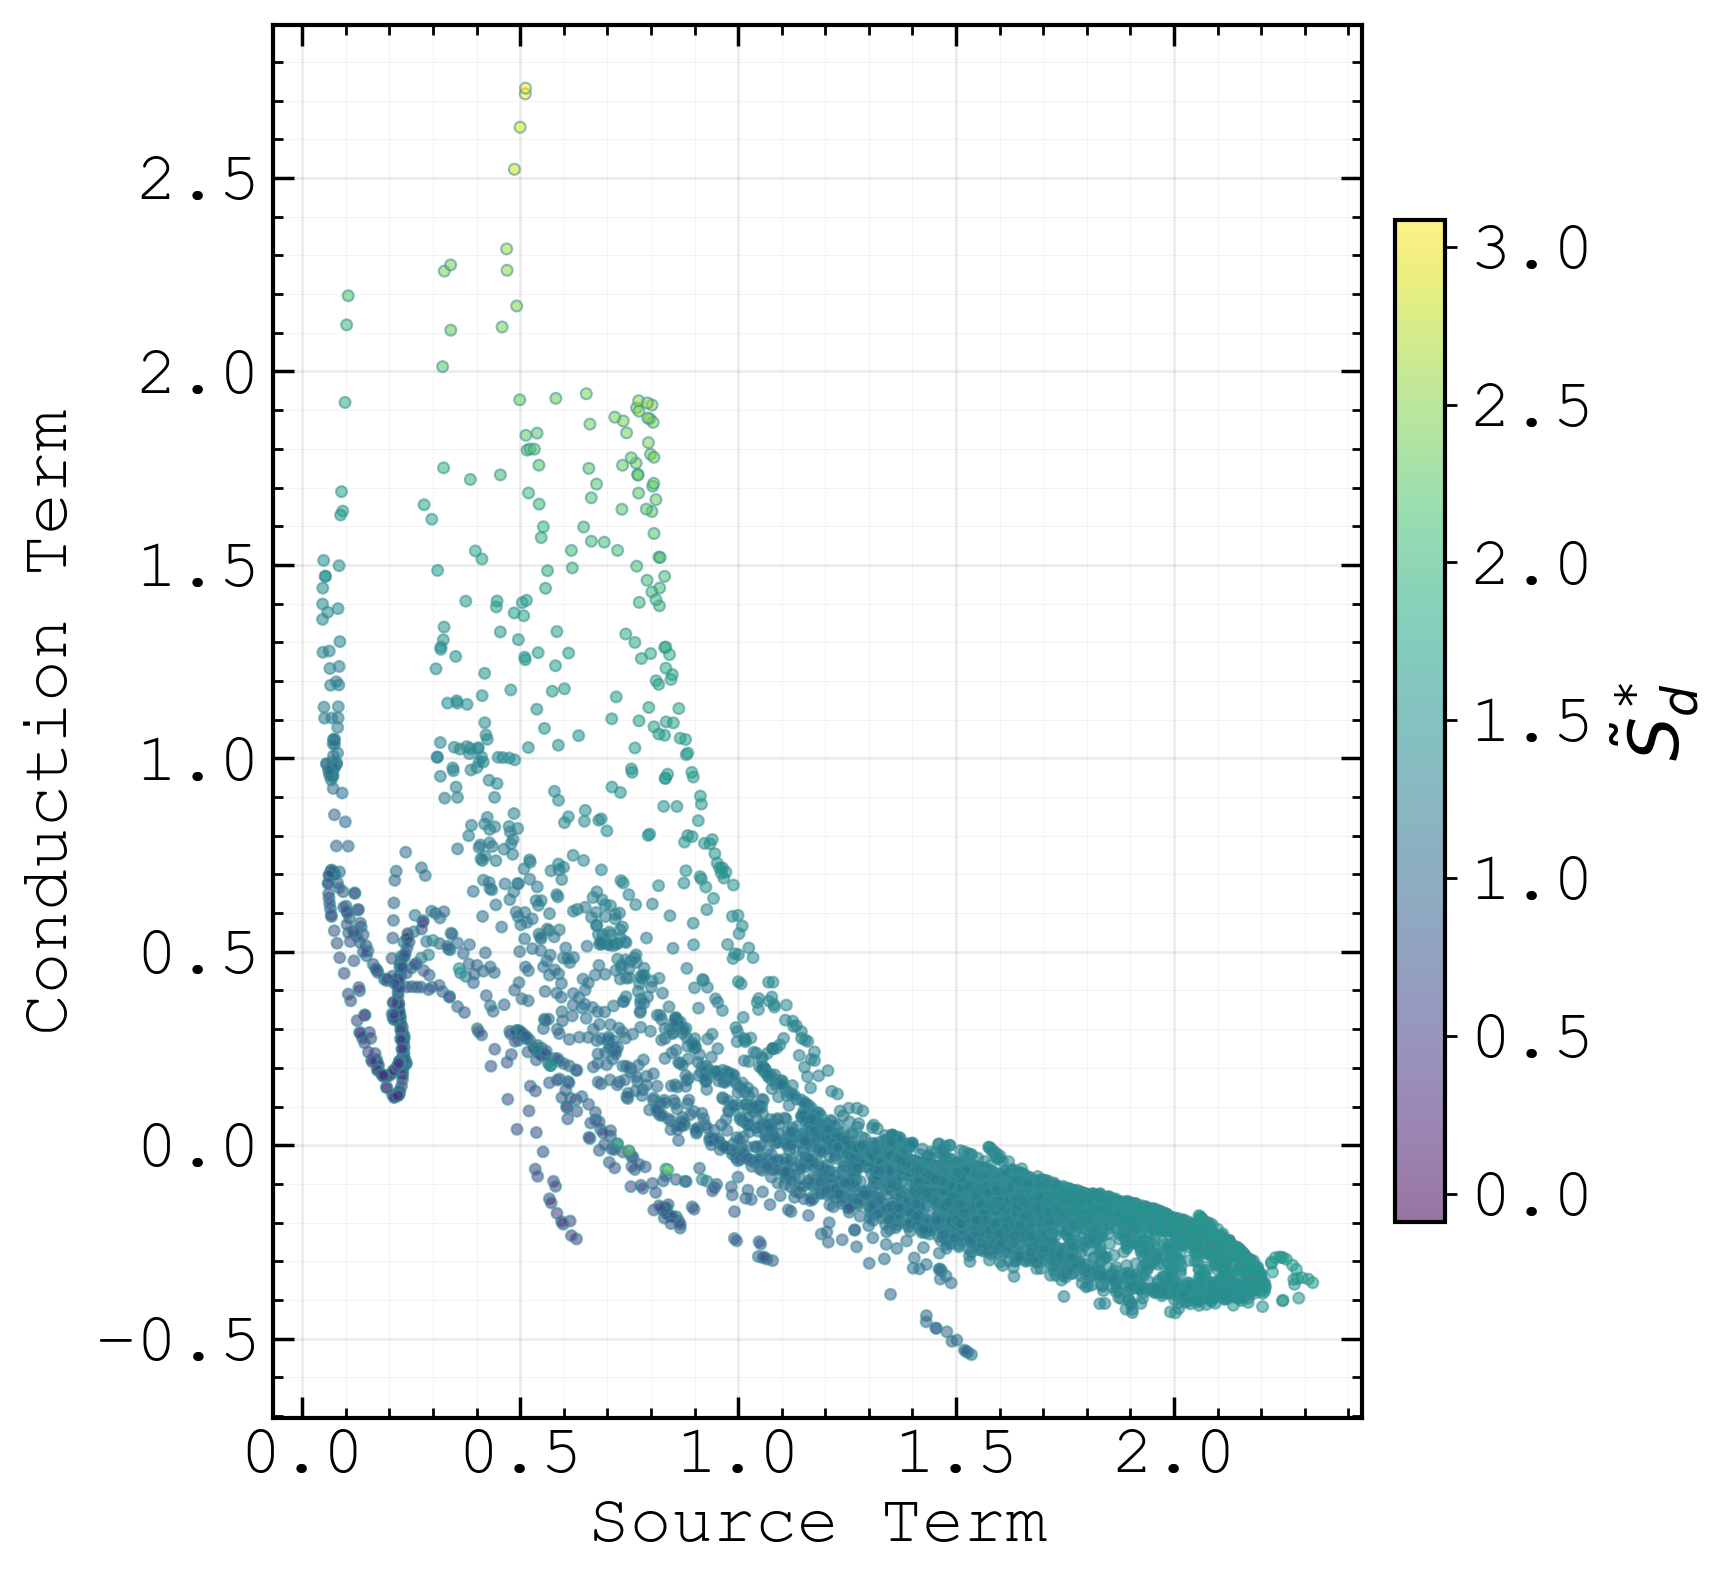

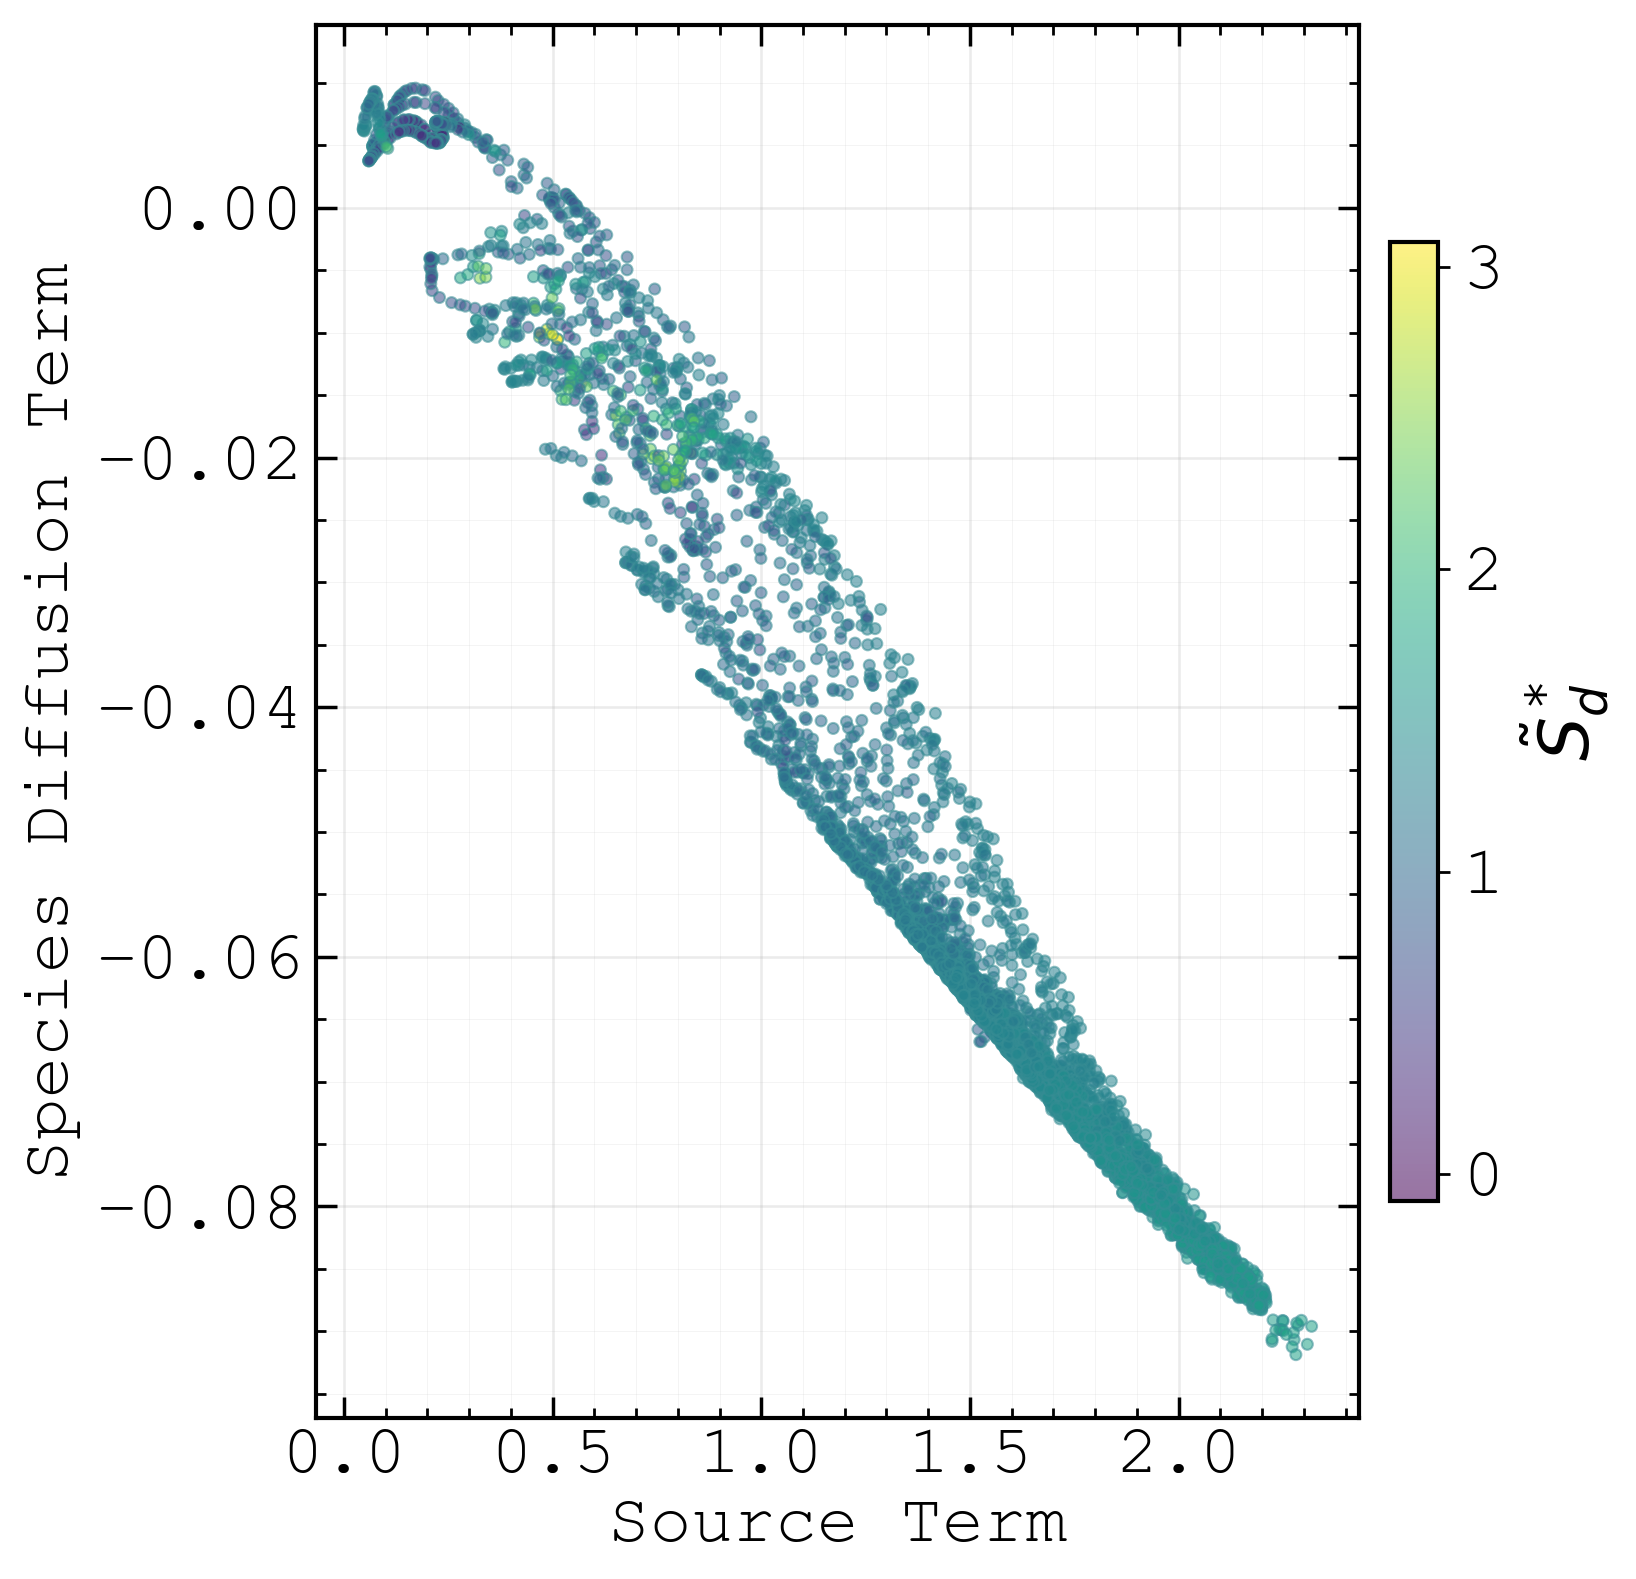

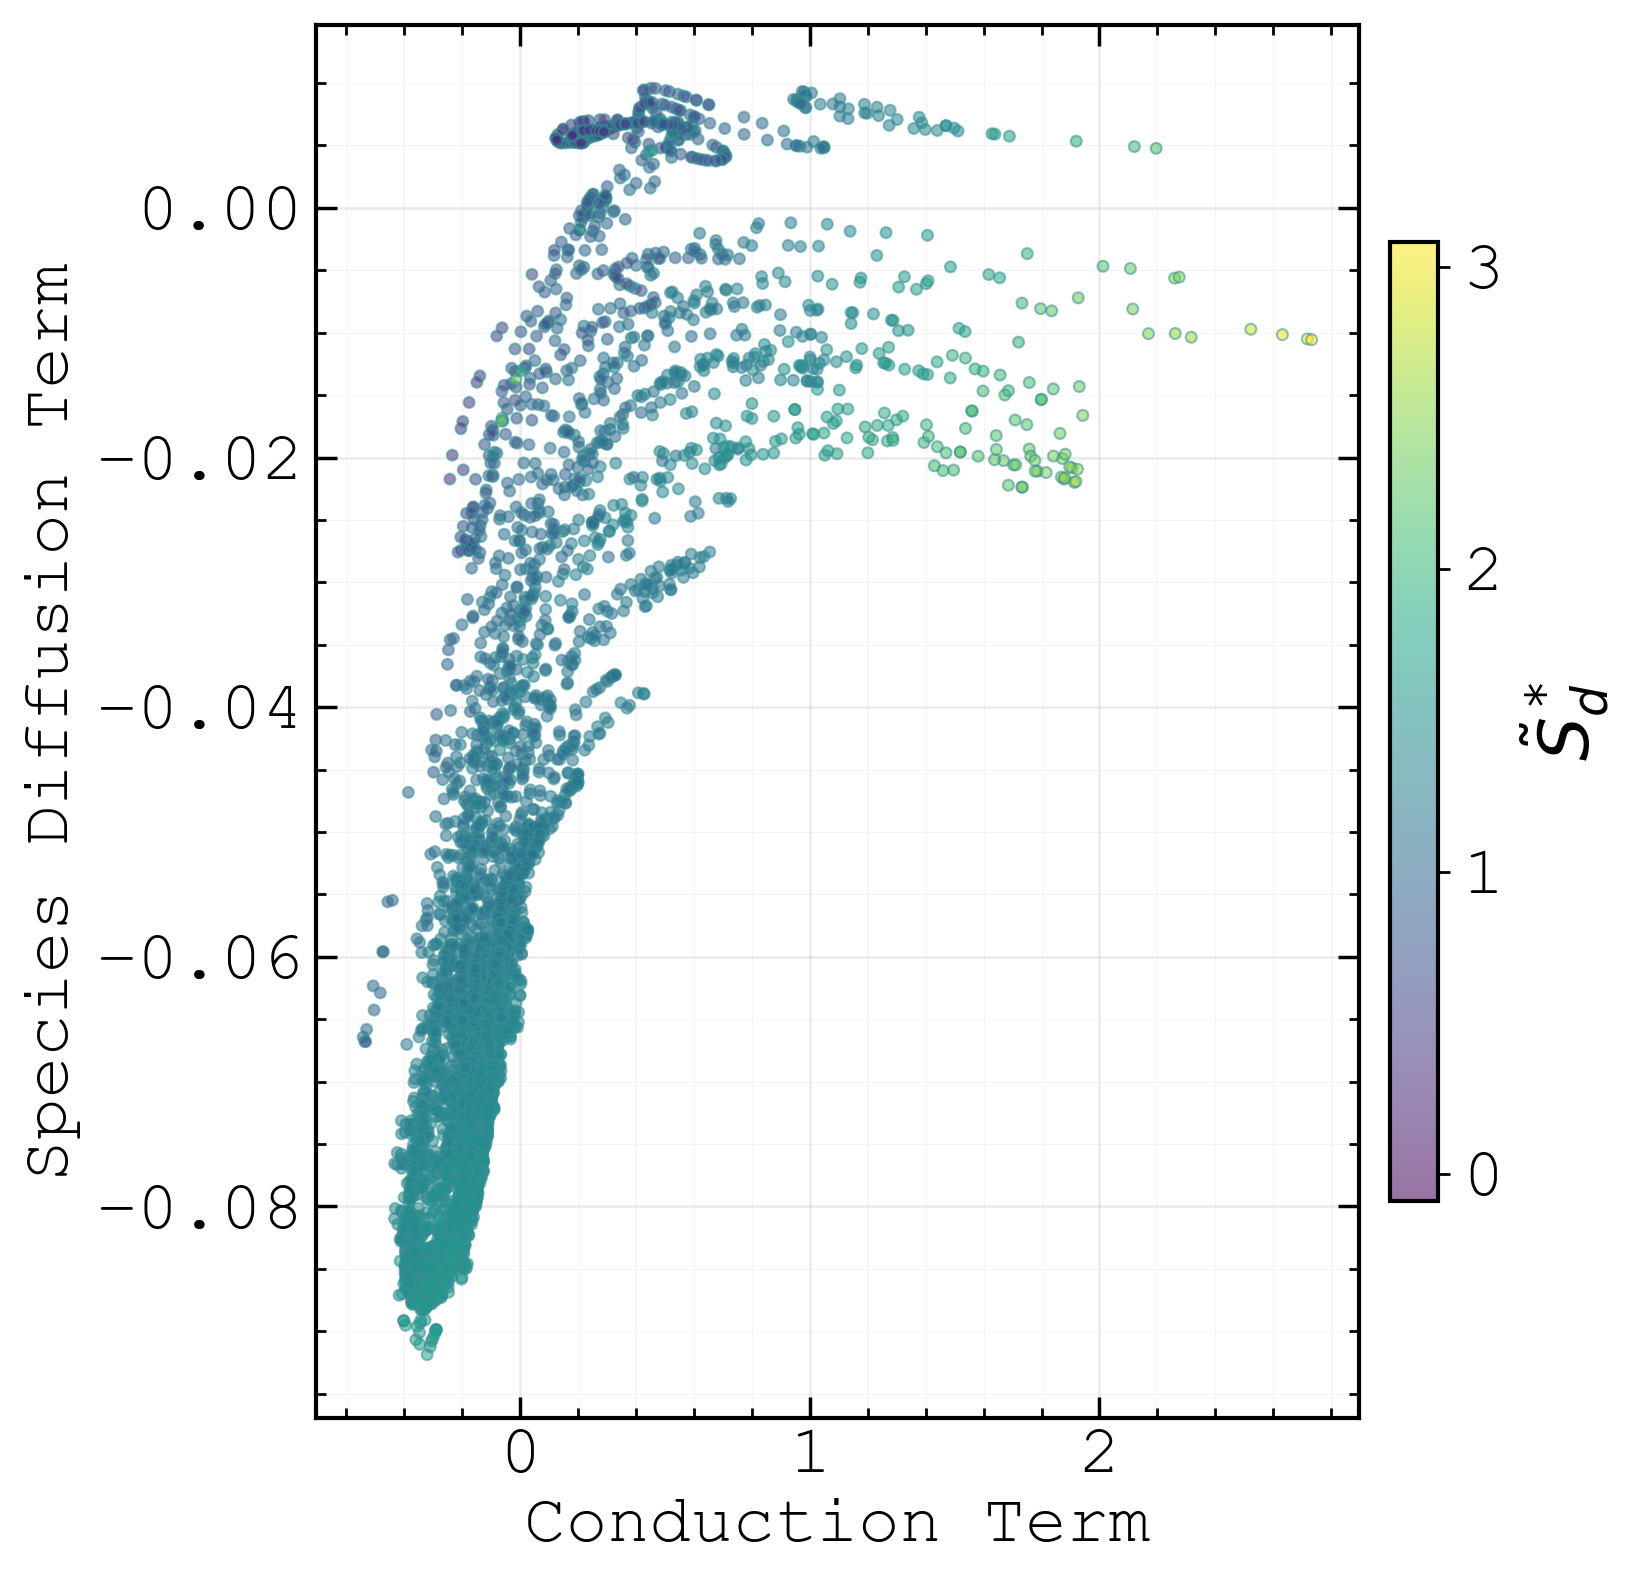

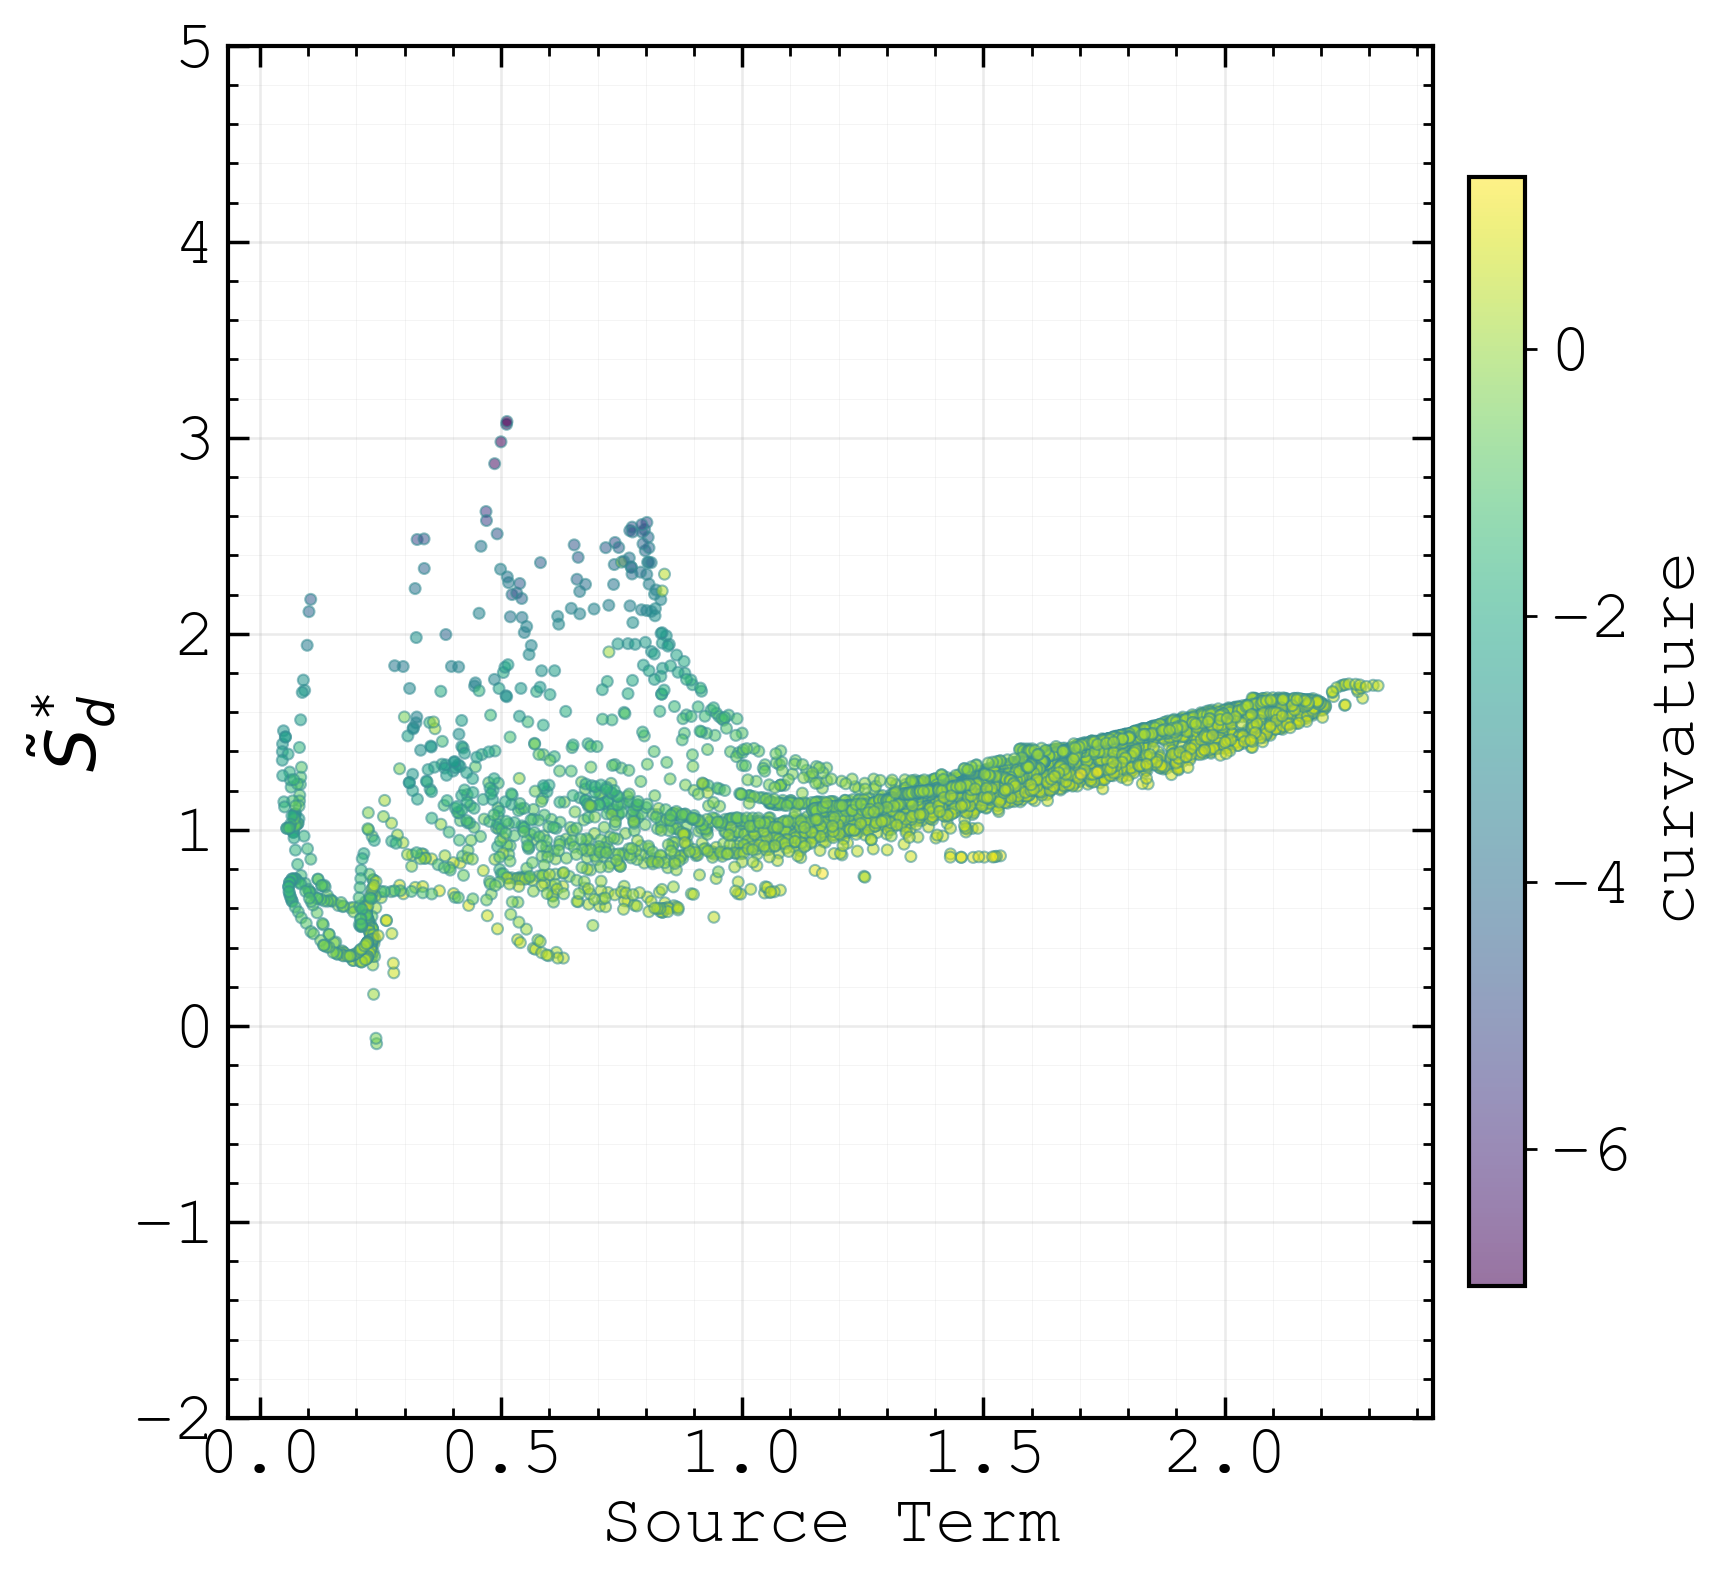

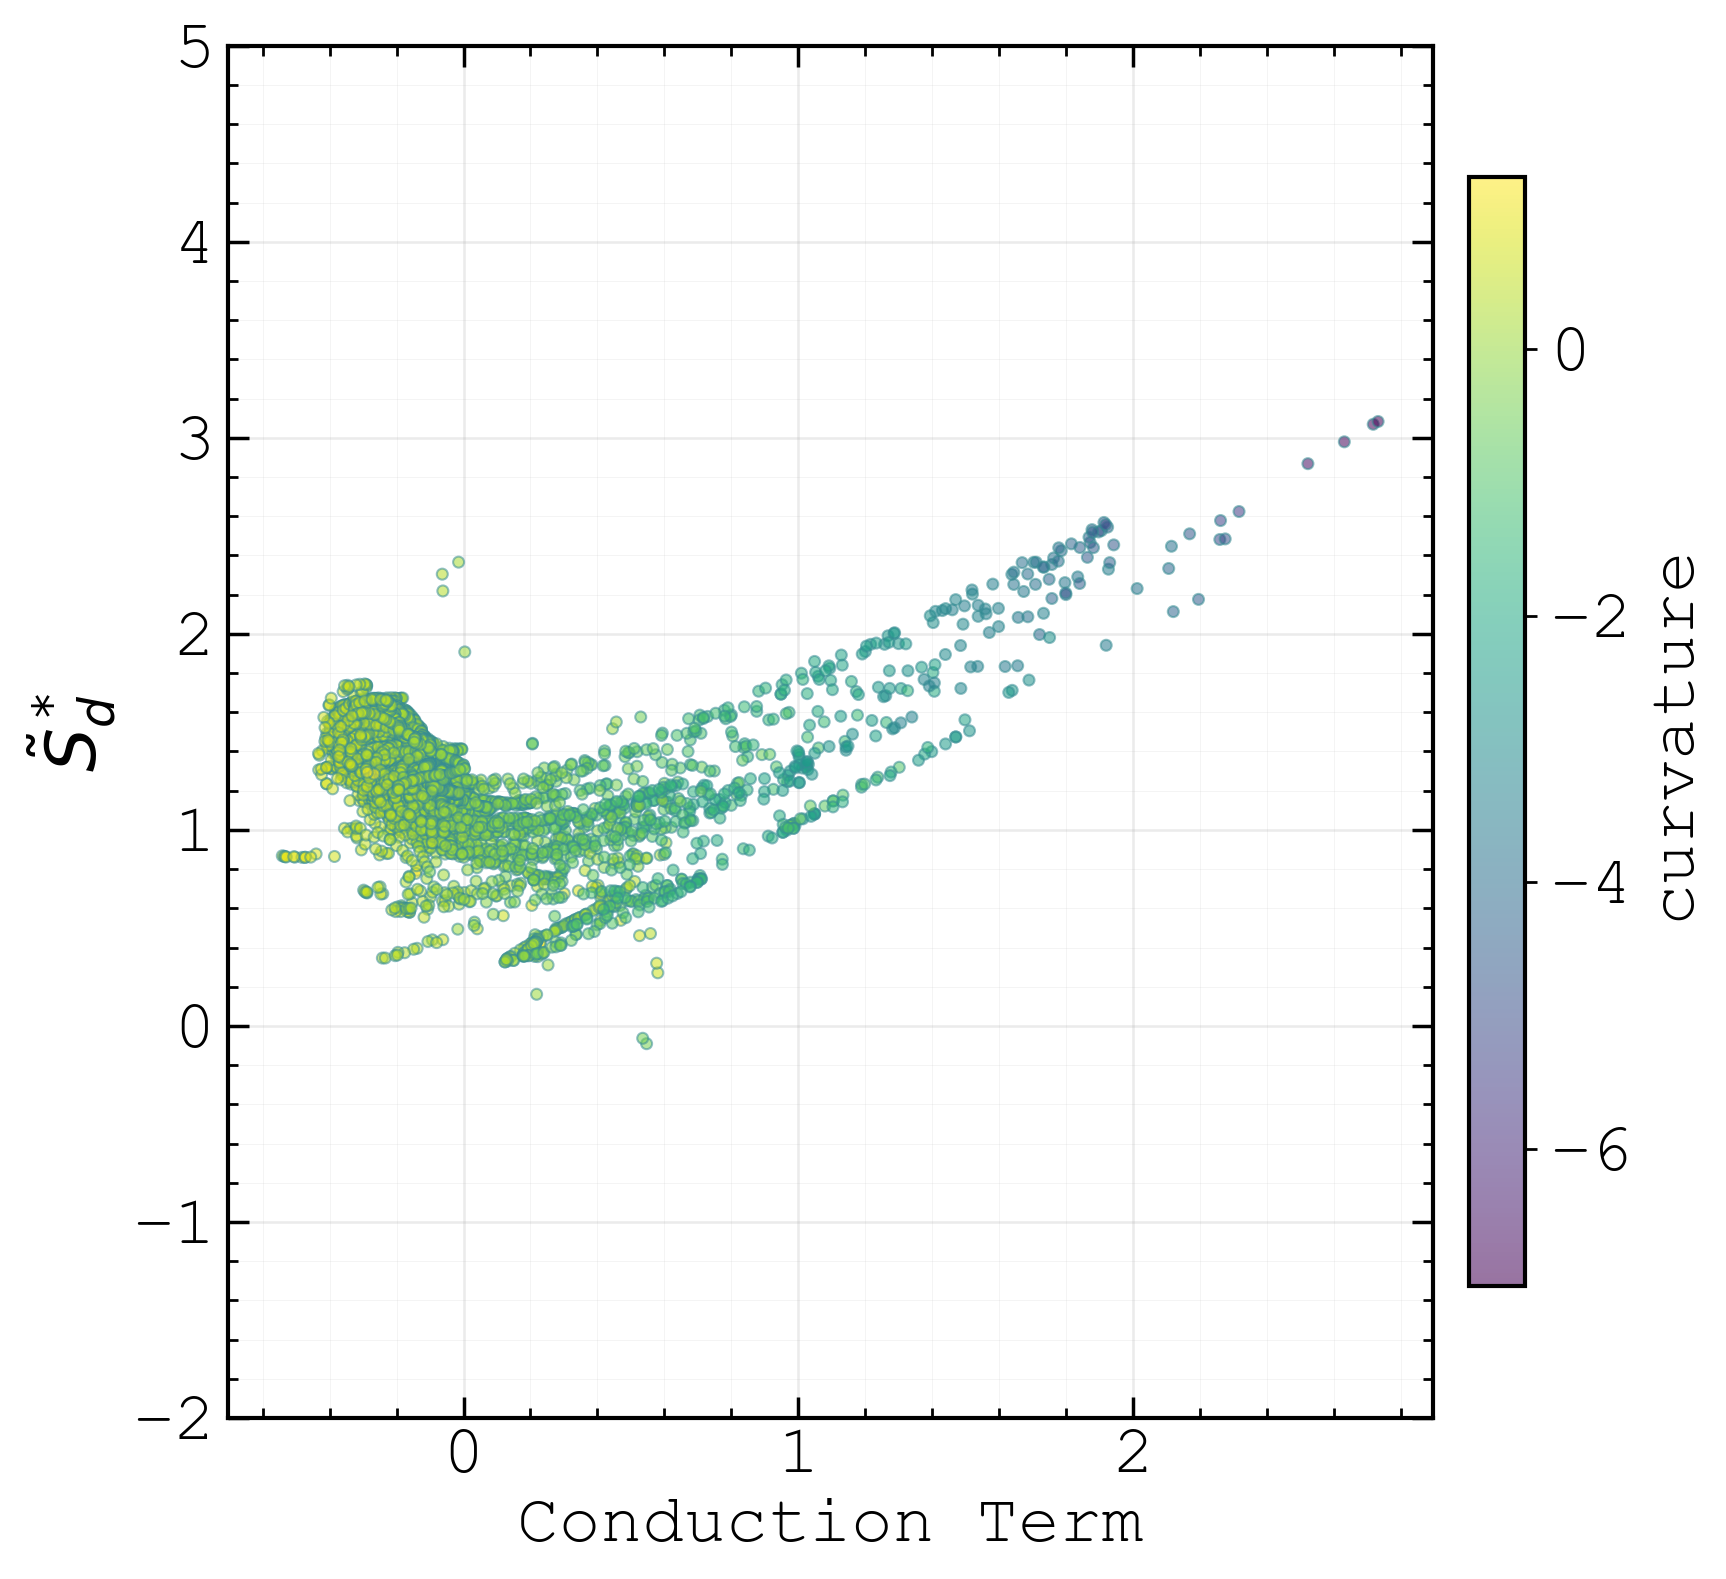

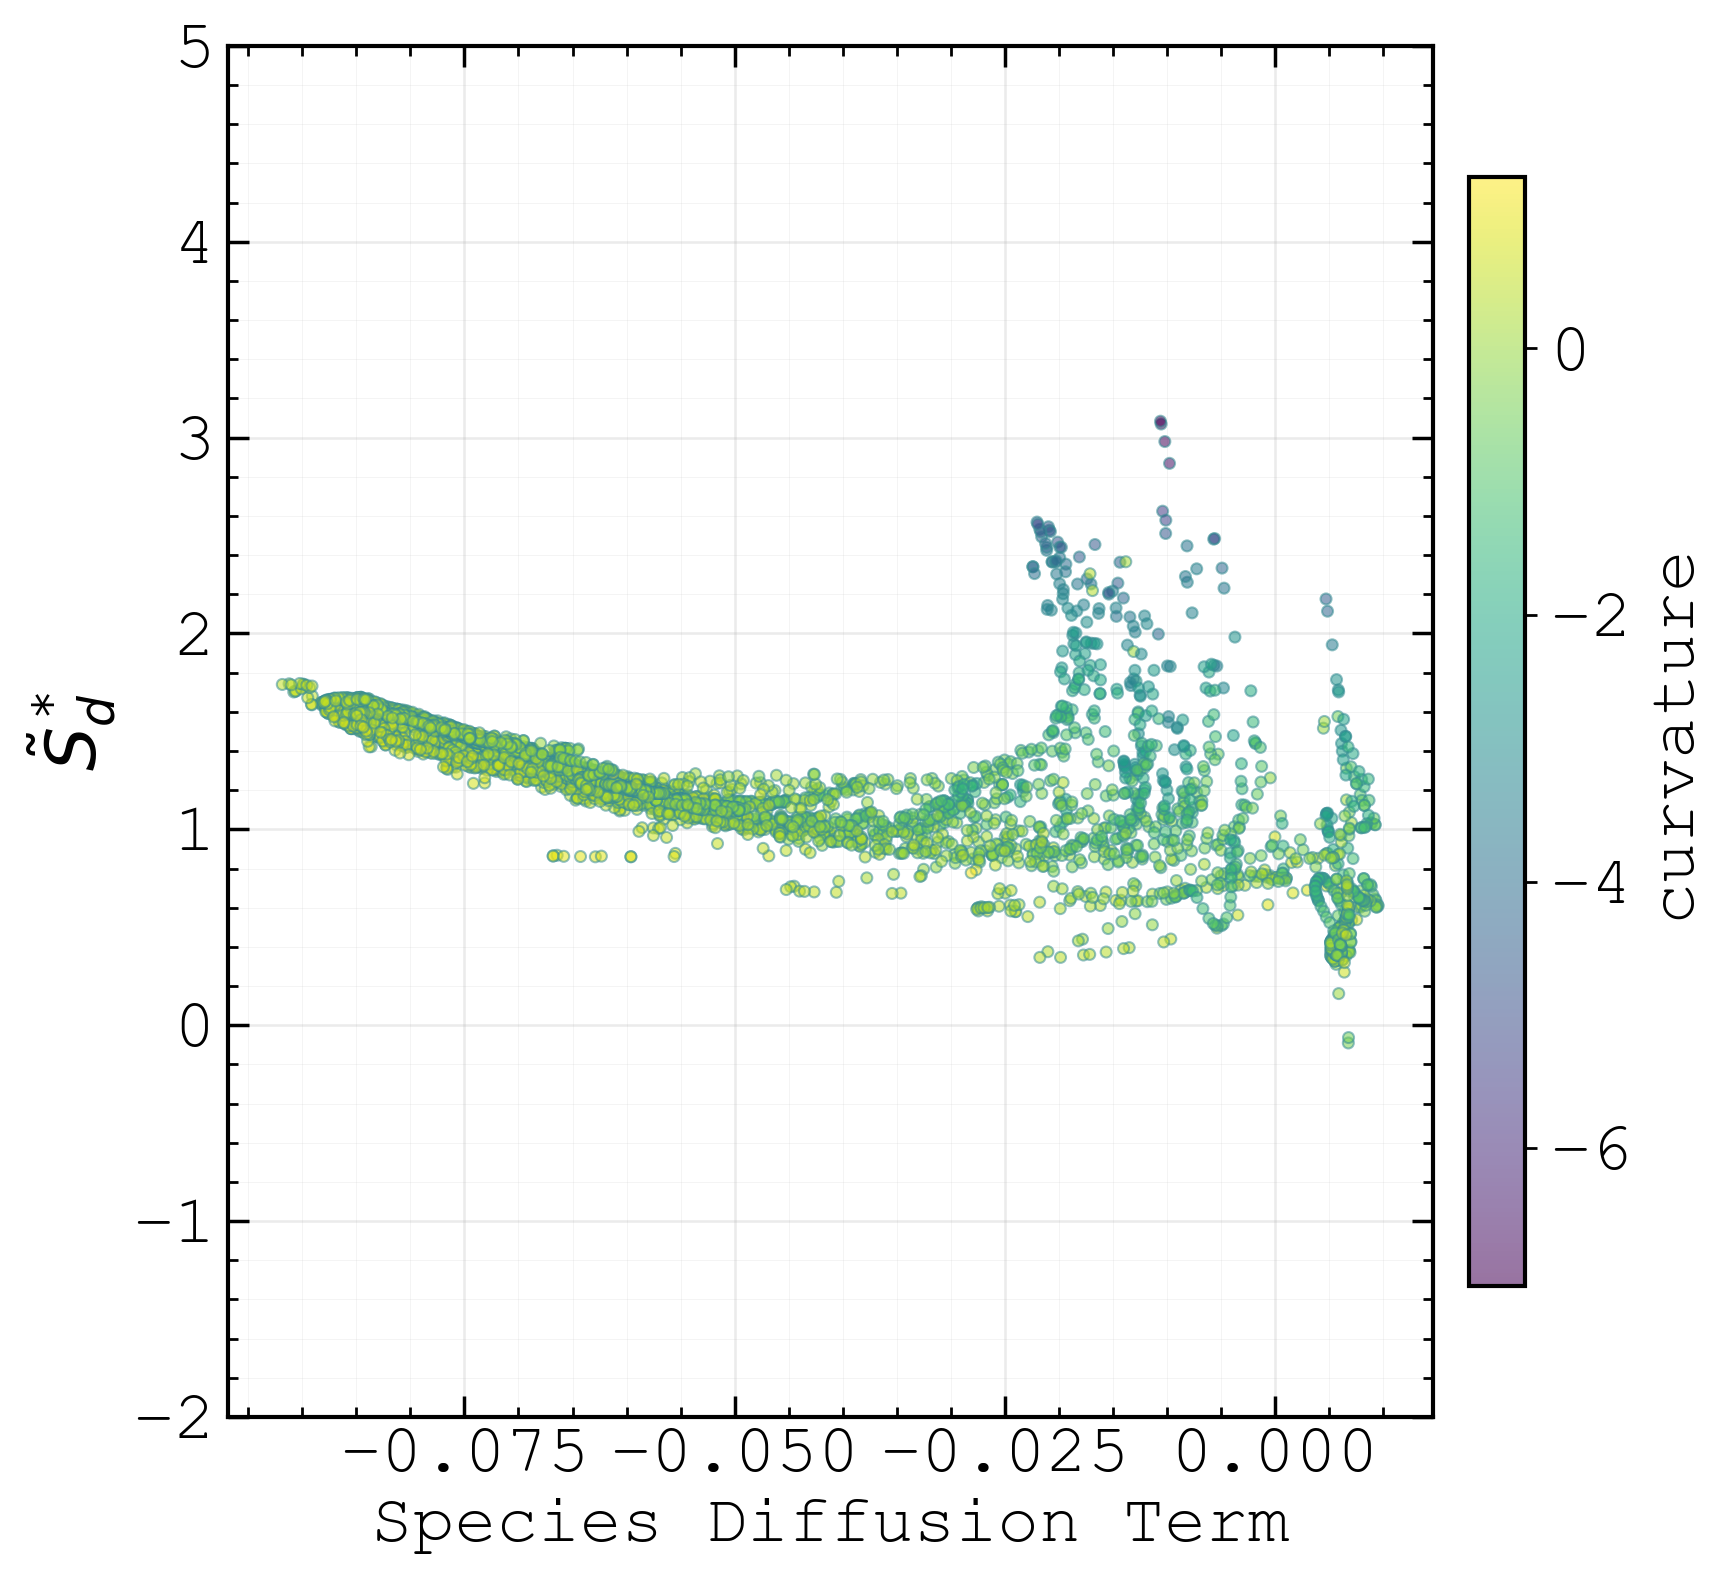

In [3]:
pairs = [
    (TERMS[0], TERMS[1]),
    (TERMS[0], TERMS[2]),
    (TERMS[1], TERMS[2]),
]

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        sd_cols = [SD_COLUMN] if sd_limits_active(SD_MIN, SD_MAX) else []
        require_columns(front, TERMS + [TARGET] + sd_cols, context=f"t={t}, ISO {c_val}:")
        out_dir = make_out_dir(LAT_SIZE, t, float(c_val))
        if SAVE_FIGS:
            out_dir.mkdir(parents=True, exist_ok=True)

        # Valid rows for both cross-plots and DW-vs-feature plots
        cols_needed = TERMS + [TARGET, CURVATURE_COLUMN] + sd_cols
        dfv = clean_valid_rows(front, cols_needed)
        dfv = apply_sd_filter(dfv, SD_COLUMN, SD_MIN, SD_MAX)

        if len(dfv) < MIN_SAMPLES:
            print(f"t={t}, T={float(c_val):.2f}: skipped (n={len(dfv)} < {MIN_SAMPLES})")
            continue

        # --------------------------
        # 0) Isocontour scatter (x vs y)
        # --------------------------
        require_columns(front, ["x", "y"], context=f"t={t}, ISO {c_val}:")
        df_iso = clean_valid_rows(front, ["x", "y"])
        iso_savepath = None
        if SAVE_FIGS:
            iso_dir = ISO_SCATTER_DIR / f"h_{LAT_SIZE}_t_{t}_T_{float(c_val):g}"
            iso_dir.mkdir(parents=True, exist_ok=True)
            iso_savepath = iso_dir / "isocontour_scatter"
        plot_isocontour_scatter(df_iso, savepath=iso_savepath)

        # --------------------------
        # 1) Pairwise cross-plots
        # --------------------------
        for f1, f2 in pairs:
            fname = CROSS_FNAME_FMT.format(f1=f1, f2=f2)
            savepath = (out_dir / fname) if SAVE_FIGS else None
            plot_cross_scatter(
                dfv,
                f1=f1,
                f2=f2,
                title=f"{f1} vs {f2} — t={t}, T={float(c_val):.2f}",
                savepath=savepath,
                color_by=(TARGET if COLOR_CROSS_BY_TARGET else None),
            )

        # --------------------------
        # 2) DW_FDS vs each term
        # --------------------------
        for feat in TERMS:
            fname = DWVS_FNAME_FMT.format(feat=feat)
            savepath = (out_dir / fname) if SAVE_FIGS else None
            plot_target_vs_feature(
                dfv,
                feat=feat,
                title=f"{TARGET} vs {feat} — t={t}, T={float(c_val):.2f}",
                savepath=savepath,
                color_by=CURVATURE_COLUMN,
            )

